In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder

# Linear Regression (Spectography data)

In [132]:
df = pd.read_csv("./MiningProcess_Flotation_Plant_Database.csv",decimal=",",parse_dates=["date"],infer_datetime_format=True).drop_duplicates()
df = df.sample(n=50, random_state=42)
df=df.drop(['date'], axis=1)
columns=["% Iron Feed", "% Silica Feed", "Starch Flow", "Amina Flow", "Ore Pulp Flow", "Ore Pulp pH", "Ore Pulp Density","% Silica Concentrate"]
df=df[columns]
df=df.reset_index(drop=True)

In [133]:
df.head()

,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,% Silica Concentrate
0,55.17,14.35,1808.17,441.197,396.862000,9.48686,1.59560,4.90
1,64.03,6.26,3533.51,447.644,399.085000,10.25880,1.67029,1.49
2,48.46,24.90,2527.44,484.740,384.751000,8.95432,1.60299,1.26
3,56.09,15.79,3448.49,556.811,413.453774,9.37545,1.64578,1.98
4,55.78,12.85,3283.95,440.219,396.885000,9.82755,1.55608,2.20


In [134]:
Y = df['% Silica Concentrate']
X = df.drop(['% Silica Concentrate'], axis=1)

In [135]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
from sklearn.linear_model import LinearRegression
reg = LinearRegression()
_ = reg.fit(X_train, Y_train)
predictions = reg.predict(X_test)
error = mean_squared_error(Y_test, predictions)
print("Print Error rate : ",error)

Print Error rate :  2.0319756586955235


In [136]:
import torch
import torch.nn as nn
import torch.optim as optim

class ImageRatingNetwork(nn.Module):
    def __init__(self):
        super(ImageRatingNetwork, self).__init__()
        self.fc1 = nn.Linear(256 * 256, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 4)

    def forward(self, x):
        x = x.view(-1, 256 * 256)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

image_rating_net = ImageRatingNetwork()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(image_rating_net.parameters(), lr=0.001)
Neural_net=0
dummy_input = torch.randn(1, 256, 256)
output_scores = image_rating_net(dummy_input)

print("Ore Grade:", torch.argmax(output_scores, dim=1))

Ore Grade: tensor([3])


In [137]:
def predictGrade(x_sample, img_path):
    # Spectrometer Prediction
    
    feature_names = ["% Iron Feed", "% Silica Feed", "Starch Flow", "Amina Flow", "Ore Pulp Flow", "Ore Pulp pH", "Ore Pulp Density"]
    data = pd.DataFrame([x_sample], columns=feature_names)

    spect_out=reg.predict(data)
    # print(spect_out)
    Final_score=spect_out[0]
    #Image Processing output
    if(Neural_net):
        image = Image.open(img_path)
        transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
        ])
        input_image = transform(image)
        input_image = input_image.unsqueeze(0)
        image_rating_net.eval()
        output_scores = image_rating_net(input_image)
        nn_out=torch.unique(torch.argmax(output_scores, dim=1))

        # Weighted Average of Visual and Spectro features
        Final_score= 0.3* nn_out + 0.7* spect_out
        return Final_score[0]
    
    return Final_score


# import requests
# from io import BytesIO
# image_url = "https://upload.wikimedia.org/wikipedia/commons/5/5d/Mother_Lode_Gold_OreHarvard_mine_quartz-gold_vein.jpg"
# response = requests.get(image_url)
# image_path = BytesIO(response.content)

In [138]:
image_path = ".\photo1.jpg"
# "% Iron Feed", "% Silica Feed", "Starch Flow", "Amina Flow", "Ore Pulp Flow", "Ore Pulp pH", "Ore Pulp Density"
print(f"% Silica Impurity is : {predictGrade([55.17, 14.35,	1808.17, 441.197, 396.862000, 9.48686	,1.59560 ], image_path):.{2}f} ") 

% Silica Impurity is : 2.53 


In [139]:
df.head(1)

,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,% Silica Concentrate
0,55.17,14.35,1808.17,441.197,396.862,9.48686,1.5956,4.9


In [140]:
predictions = reg.predict(X_test)
error = mean_squared_error(Y_test, predictions)
print("Print Error rate : ",error)

Print Error rate :  2.0319756586955235


# Training

In [141]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder

# Assuming your dataset directory structure is as follows:
# root
# ├── grade_1
# ├── grade_2
# ├── grade_3
# └── grade_4

# Define a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.dataset = ImageFolder(root=root_dir, transform=transform)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        return img, label

# Define a set of transformations to be applied to the images
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize images to 256x256
    transforms.ToTensor()  # Convert to PyTorch tensor
])

# Specify the path to your dataset
dataset_root = "./ore_images/"

# Create an instance of the custom dataset
custom_dataset = CustomDataset(root_dir=dataset_root, transform=transform)

# Create a DataLoader
batch_size = 2  # You can adjust this based on your available resources
train_loader = DataLoader(dataset=custom_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

# Now, `train_loader` can be used in your training loop

Batch 1 - Inputs: torch.Size([2, 3, 256, 256]), Labels: tensor([0, 1])


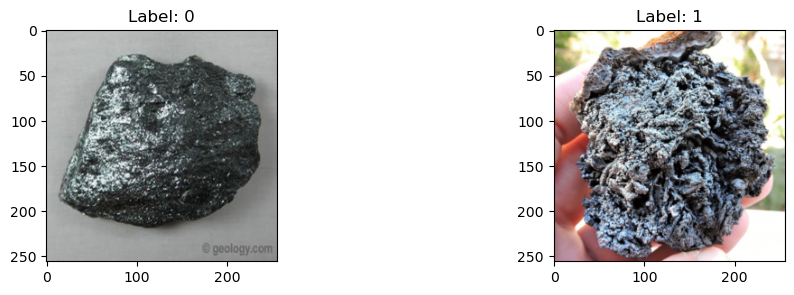

Batch 2 - Inputs: torch.Size([2, 3, 256, 256]), Labels: tensor([1, 0])


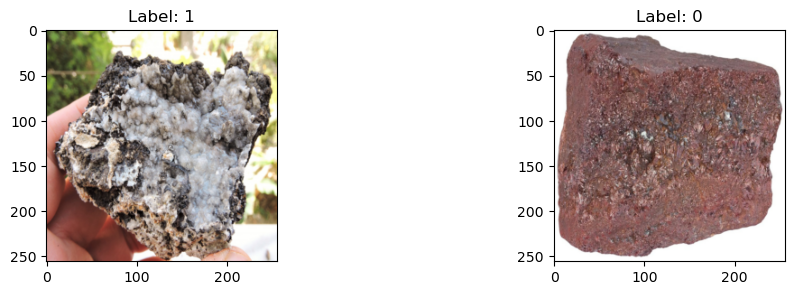

Batch 3 - Inputs: torch.Size([2, 3, 256, 256]), Labels: tensor([1, 1])


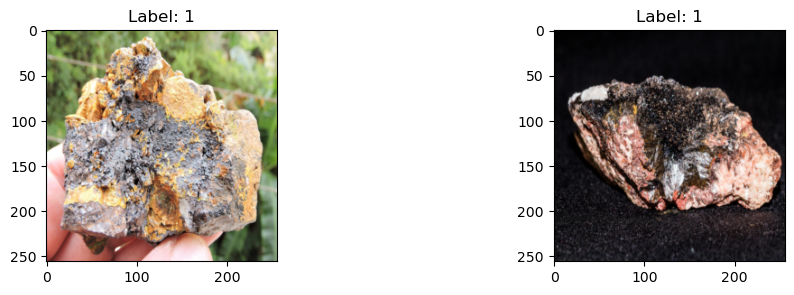

Batch 4 - Inputs: torch.Size([2, 3, 256, 256]), Labels: tensor([1, 2])


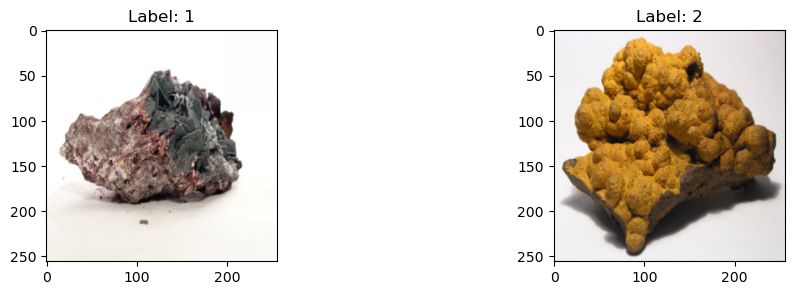

In [142]:
# Assuming you have a DataLoader named train_loader for your training data

# Iterate over the batches in the training set
for batch_idx, (inputs, labels) in enumerate(train_loader):
    # Print or visualize the data
    print(f"Batch {batch_idx + 1} - Inputs: {inputs.shape}, Labels: {labels}")

    # If you want to visualize the images (assuming they are in tensor format)
    import matplotlib.pyplot as plt

    # Assuming the batch size is 4 for demonstration purposes
    if batch_idx < 4:
        fig, axes = plt.subplots(1, len(inputs), figsize=(12, 3))

        for i in range(len(inputs)):
            # Assuming images are normalized tensors
            img = inputs[i].permute(1, 2, 0).numpy()
            axes[i].imshow(img)
            axes[i].set_title(f"Label: {labels[i]}")

        plt.show()

    # Break the loop to only visualize the first few batches
    if batch_idx == 3:
        break


In [143]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets

# Assuming you have a dataset class (CustomDataset) and the necessary data loaders
# Define the CNN architecture
class OreClassifier(nn.Module):
    def __init__(self):
        super(OreClassifier, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 64 * 64, 64)  # Adjust the output size to match your Keras model
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 4)

    def forward(self, x):
        x = self.pool1(self.relu(self.conv1(x)))
        x = self.pool2(self.relu(self.conv2(x)))
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x
# Instantiate the model
ore_classifier = OreClassifier()

# Choose the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(ore_classifier.parameters(), lr=0.001)

# Assuming you have a DataLoader named train_loader for your training data
# Iterate over epochs
num_epochs = 5
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    
    # Iterate over the batches in the training set
    for batch_idx, (inputs, labels) in enumerate(train_loader):
        # Forward pass
        outputs = ore_classifier(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print training statistics
        if (batch_idx + 1) % 10 == 0:  # Print every 10 batches
            print(f"Batch {batch_idx + 1}/{len(train_loader)} - Loss: {loss.item():.4f}")

# After training, you can use the model for predictions on new data
# Example:
# ore_classifier.eval()
# with torch.no_grad():
#     predicted_labels = ore_classifier(new_data)

# Remember to adapt the architecture and hyperparameters based on the specifics of your dataset and task.


Epoch 1/5
Batch 10/14 - Loss: 1.4126
Epoch 2/5
Batch 10/14 - Loss: 1.0898
Epoch 3/5
Batch 10/14 - Loss: 0.4414
Epoch 4/5
Batch 10/14 - Loss: 0.2152
Epoch 5/5
Batch 10/14 - Loss: 0.0205


In [144]:
ore_classifier.eval()

img_path = "ore_images\GRADE_D\GRADE_D_3.jpg"
image = Image.open(img_path)
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

input_image = transform(image)
input_image = input_image.unsqueeze(0)

with torch.no_grad():
    predicted_labels = ore_classifier(input_image)

probabilities = F.softmax(predicted_labels, dim=1)

predicted_class_index = torch.argmax(probabilities, dim=1).item()

class_names = [ 'Class 1', 'Class 2', 'Class 3', 'Class 4']

print("Predicted Probabilities:")
for i, probability in enumerate(probabilities.squeeze().tolist()):
    print(f"{class_names[i]}: {probability:.2f}")

print(f"Predicted Class Index: {predicted_class_index}")

Predicted Probabilities:
Class 1: 0.00
Class 2: 0.00
Class 3: 0.00
Class 4: 1.00
Predicted Class Index: 3


In [16]:
torch.save(ore_classifier.state_dict(), 'ore_classifier.pth')

# Final Work

In [149]:
# Link Images with dataset for SIMULATION
df = pd.read_csv("./MiningProcess_Flotation_Plant_Database.csv",decimal=",",parse_dates=["date"],infer_datetime_format=True).drop_duplicates()
df=df.drop(['date'], axis=1)
columns=["% Iron Feed", "% Silica Feed", "Starch Flow", "Amina Flow", "Ore Pulp Flow", "Ore Pulp pH", "Ore Pulp Density","% Silica Concentrate"]
df=df[columns]
df=df.sample(n=50, random_state=42)
df=df.reset_index(drop=True)
# Assuming your DataFrame is named df
num_bins = 4  # Number of bins (grades)

# Use qcut to distribute grades equally based on '% Silica Concentrate'
df['Grade'], bins = pd.qcut(df['% Silica Concentrate'], q=num_bins, labels=False, retbins=True)

# Assign labels to the grades
grade_labels = list(range(num_bins))
df['Grade'] = df['Grade'].map({i: label for i, label in enumerate(grade_labels)})
df.head(100)

,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,% Silica Concentrate,Grade
0,55.17,14.35,1808.170000,441.197000,396.862000,9.486860,1.595600,4.900000,3
1,64.03,6.26,3533.510000,447.644000,399.085000,10.258800,1.670290,1.490000,0
2,48.46,24.90,2527.440000,484.740000,384.751000,8.954320,1.602990,1.260000,0
3,56.09,15.79,3448.490000,556.811000,413.453774,9.375450,1.645780,1.980000,1
4,55.78,12.85,3283.950000,440.219000,396.885000,9.827550,1.556080,2.200000,2
5,54.95,17.40,3865.230000,587.891000,392.871000,9.910340,1.760000,1.730000,1
6,64.03,6.26,3016.490000,475.038000,395.187000,10.006500,1.580730,2.320000,2
7,64.03,6.26,3344.330000,480.580000,396.348000,10.110000,1.737760,1.840000,1
8,64.03,6.26,3239.390000,469.319000,400.536000,9.933890,1.663510,1.550000,0
9,58.95,8.94,3794.140000,443.665000,401.338000,9.776040,1.750000,3.880000,3


In [150]:
import pandas as pd
import os

# Assuming df is your DataFrame
# Assuming you have folders named Grade_A, Grade_B, etc. with corresponding images

# Define the path to the folders containing images
image_folder_path = "./ore_images/"
grade_mapping = {0: 'A', 1: 'B', 2: 'C', 3: 'D'}

# Set to keep track of used image filenames
used_images = set()

# Function to get the next image path from the respective grade folder
def get_next_image_path(row):
    grade_folder = os.path.join(image_folder_path, "Grade_" + grade_mapping[row['Grade']] + "/")
    images = [img for img in os.listdir(grade_folder) if img.endswith(".jpg") and img not in used_images]
    
    if not images:
        # If no unused images are left, remove the row
        return None
    
    # Use images in order
    next_image = images.pop(0)
    used_images.add(next_image)
    return os.path.join(grade_folder, next_image)

# Use qcut to distribute grades equally based on '% Silica Concentrate'
df['Grade'], bins = pd.qcut(df['% Silica Concentrate'], q=4, labels=False, retbins=True)

# Apply the function to create the 'Image_Path' column
df['Image_Path'] = df.apply(get_next_image_path, axis=1)

# Drop rows where Image_Path is None
df = df.dropna(subset=['Image_Path'])

# Reset index for better visualization
df = df.reset_index(drop=True)
# Save the updated DataFrame to a CSV file
df.to_csv("Train_dataset.csv", index=False)

# Print the updated DataFrame
print(df.head(100))

    % Iron Feed  % Silica Feed  Starch Flow  Amina Flow  Ore Pulp Flow  \
0         55.17          14.35  1808.170000  441.197000     396.862000   
1         64.03           6.26  3533.510000  447.644000     399.085000   
2         48.46          24.90  2527.440000  484.740000     384.751000   
3         56.09          15.79  3448.490000  556.811000     413.453774   
4         55.78          12.85  3283.950000  440.219000     396.885000   
5         54.95          17.40  3865.230000  587.891000     392.871000   
6         64.03           6.26  3016.490000  475.038000     395.187000   
7         64.03           6.26  3344.330000  480.580000     396.348000   
8         64.03           6.26  3239.390000  469.319000     400.536000   
9         58.95           8.94  3794.140000  443.665000     401.338000   
10        56.57          13.47  1788.810000  483.527000     398.710000   
11        54.38          17.41  2348.630000  573.611000     402.554000   
12        56.08          14.93  3771.4

In [151]:
df.head()

,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,% Silica Concentrate,Grade,Image_Path
0,55.17,14.35,1808.17,441.197,396.862000,9.48686,1.59560,4.90,3,./ore_images/Grade_D/GRADE_D_1.jpg
1,64.03,6.26,3533.51,447.644,399.085000,10.25880,1.67029,1.49,0,./ore_images/Grade_A/GRADE_A_1.jpg
2,48.46,24.90,2527.44,484.740,384.751000,8.95432,1.60299,1.26,0,./ore_images/Grade_A/GRADE_A_10.jpg
3,56.09,15.79,3448.49,556.811,413.453774,9.37545,1.64578,1.98,1,./ore_images/Grade_B/GRADE_B_1.jpg
4,55.78,12.85,3283.95,440.219,396.885000,9.82755,1.55608,2.20,2,./ore_images/Grade_C/GRADE_C_2.jpg


In [152]:
import os
import pandas as pd
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image

class OreDataset(Dataset):
    def __init__(self, csv_file, image_base_path, transform=None):
        self.data_frame = pd.read_csv(csv_file)
        self.image_base_path = image_base_path
        self.transform = transform

        # # Define a mapping for class labels to numerical values
        self.label_mapping = {'A': 0, 'B': 1, 'C': 2, 'D': 3}
        self.label_mapping = {0 : 0, 1 : 1, 2 : 2, 3 : 3}
        

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        iron_feed = self.data_frame.iloc[idx, 0]
        silica_feed = self.data_frame.iloc[idx, 1]
        starch_flow = self.data_frame.iloc[idx, 2]
        amina_flow = self.data_frame.iloc[idx, 3]
        ore_pulp_flow = self.data_frame.iloc[idx, 4]
        ore_pulp_ph = self.data_frame.iloc[idx, 5]
        ore_pulp_density = self.data_frame.iloc[idx, 6]
        silica_concentrate = self.data_frame.iloc[idx, 7]
        grade = self.data_frame.iloc[idx, 8]
        image_path = self.data_frame.iloc[idx, 9]

        # Combine the base path and the image_path from the CSV
        image_path = os.path.join(self.image_base_path, image_path)

        # Load the image
        img = Image.open(image_path).convert('RGB')

        if self.transform:
            img = self.transform(img)

        label = torch.tensor(self.label_mapping[grade], dtype=torch.long)

        return {
            'iron_feed': iron_feed,
            'silica_feed': silica_feed,
            'starch_flow': starch_flow,
            'amina_flow': amina_flow,
            'ore_pulp_flow': ore_pulp_flow,
            'ore_pulp_ph': ore_pulp_ph,
            'ore_pulp_density': ore_pulp_density,
            'silica_concentrate': silica_concentrate,
            'image': img,
            'label': label
        }


In [189]:

# Specify the path to the CSV file and the base path for the images
csv_file = './Train_dataset.csv'
image_base_path = ''

# Define the transformation for the image
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Create an instance of the custom dataset
ore_dataset = OreDataset(csv_file=csv_file, image_base_path=image_base_path, transform=transform)

# Create a DataLoader
train_loader = DataLoader(dataset=ore_dataset, batch_size=4, shuffle=True)

Batch 1 - Iron Feed: tensor([64.0300, 52.1100, 55.7800, 53.6800], dtype=torch.float64), Silica Feed: tensor([ 6.2600, 18.6400, 12.8500, 19.0800], dtype=torch.float64), Label: tensor([0, 0, 2, 1])


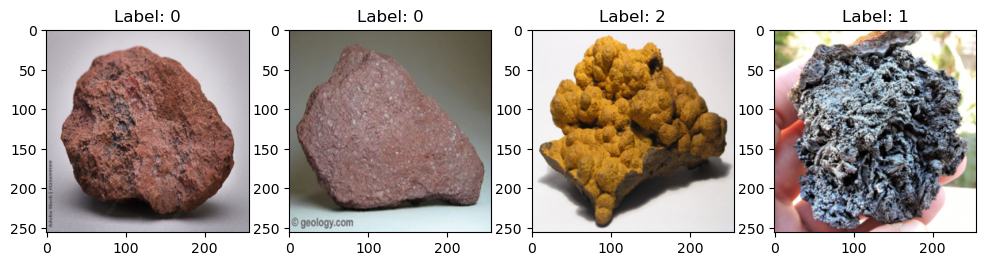

Batch 2 - Iron Feed: tensor([52.1500, 56.3900, 55.1700, 64.0300], dtype=torch.float64), Silica Feed: tensor([21.5000, 13.5300, 14.3500,  6.2600], dtype=torch.float64), Label: tensor([3, 3, 3, 1])


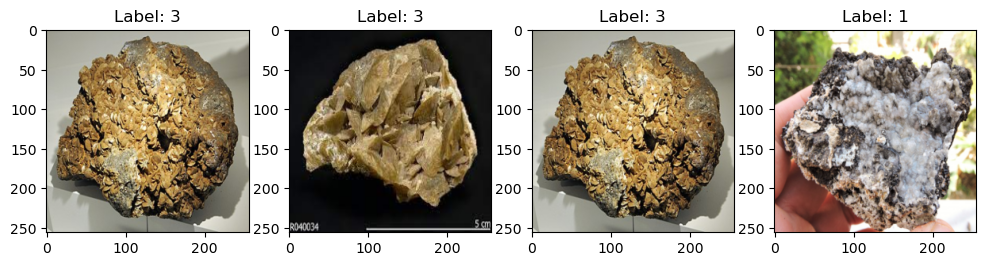

Batch 3 - Iron Feed: tensor([56.0900, 54.1000, 56.0800, 64.0300], dtype=torch.float64), Silica Feed: tensor([15.7900, 15.3300, 14.9300,  6.2600], dtype=torch.float64), Label: tensor([1, 0, 3, 1])


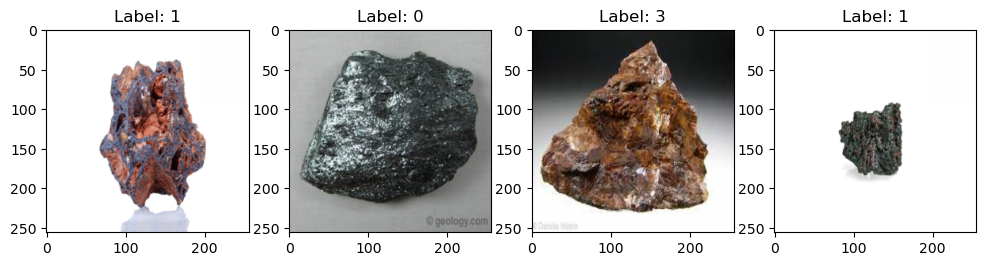

Batch 4 - Iron Feed: tensor([64.0300, 55.1700, 54.3800, 64.0300], dtype=torch.float64), Silica Feed: tensor([ 6.2600, 14.3500, 17.4100,  6.2600], dtype=torch.float64), Label: tensor([0, 3, 3, 1])


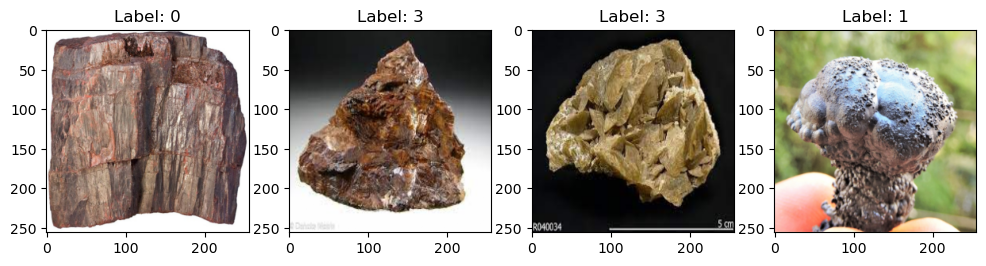

In [190]:
import matplotlib.pyplot as plt

# Iterate over the batches in the training set
for batch_idx, batch in enumerate(train_loader):
    # Print or visualize the data
    print(f"Batch {batch_idx + 1} - Iron Feed: {batch['iron_feed']}, Silica Feed: {batch['silica_feed']}, Label: {batch['label']}")

    # If you want to visualize the images (assuming they are in tensor format)
    if 'image' in batch:
        images = batch['image']
        labels = batch['label']

        # Assuming the batch size is 4 for demonstration purposes
        if batch_idx < 4:
            fig, axes = plt.subplots(1, len(images), figsize=(12, 3))

            for i in range(len(images)):
                # Assuming images are normalized tensors
                img = images[i].permute(1, 2, 0).numpy()
                axes[i].imshow(img)
                axes[i].set_title(f"Label: {labels[i]}")

            plt.show()

    # Break the loop to only visualize the first few batches
    if batch_idx == 3:
        break


In [191]:
class  ImageCNN(nn.Module):
    def __init__(self):
        super(ImageCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 64 * 64, 64)  
        self.fc2 = nn.Linear(64+1, 4)

    def forward(self, x,silica_impurity):
        x = self.pool1(self.relu(self.conv1(x)))
        x = self.pool2(self.relu(self.conv2(x)))
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        combined_features = torch.cat((x, silica_impurity.unsqueeze(1)), dim=1)
        x = self.fc2(combined_features)
        return x

In [192]:
import torch.optim as optim

# Instantiate the combined model
image_cnn = ImageCNN()

# Choose the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(image_cnn.parameters(), lr=0.001)

# Assuming you have a DataLoader named train_loader for your training data
# Iterate over epochs
num_epochs = 7
for epoch in range(num_epochs):
    # Iterate over the batches in the training set
    for batch in train_loader:
        images = batch['image']
        silica_impurity = batch['silica_concentrate'].float() 
        labels=batch['label']

        # Forward pass
        outputs = image_cnn(images, silica_impurity)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}')

torch.save(image_cnn.state_dict(), 'combined_model2.pth')

Epoch [1/7], Loss: 1.2919059991836548
Epoch [2/7], Loss: 1.30143141746521
Epoch [3/7], Loss: 0.7531050443649292
Epoch [4/7], Loss: 0.04885401949286461
Epoch [5/7], Loss: 0.016593702137470245
Epoch [6/7], Loss: 0.008705411106348038
Epoch [7/7], Loss: 0.007035117130726576


In [200]:
image_cnn.eval()

img_path = "ore_images\GRADE_D\GRADE_D_5.jpg"
image = Image.open(img_path)
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])  

input_image = transform(image)
input_image = input_image.unsqueeze(0)

silica_imp=torch.Tensor([55])
with torch.no_grad():
    predicted_labels = image_cnn(input_image, silica_imp)

probabilities = F.softmax(predicted_labels, dim=1)

predicted_class_index = torch.argmax(probabilities, dim=1).item()

class_names = [ 'Grade A', 'Grade B', 'Grade C', 'Grade D']

print("Predicted Probabilities:")
for i, probability in enumerate(probabilities.squeeze().tolist()):
    print(f"{class_names[i]}: {probability:.2f}")

print(f"Predicted Class Index: {predicted_class_index}")

Predicted Probabilities:
Grade A: 0.00
Grade B: 0.00
Grade C: 0.00
Grade D: 1.00
Predicted Class Index: 3
